# Variational Autoencoders

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
from torchsummary import summary
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data loading

In [ ]:
savePath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/'
# savePath = 'G:/Il mio Drive/Secondo Anno Magistrale/Machine Learning/'
def loadData(sPath):
  images = np.load(savePath+'images.npy')
  labels = np.load(savePath+'labels.npy')
  return(images, labels)

X, y = loadData(savePath)

From string response to numeric

In [ ]:
labEnc = LabelEncoder()
y_num = labEnc.fit_transform(y) 
label_dict = {label: i for i, label in enumerate(labEnc.classes_)}
print(label_dict)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


Dataloader

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = np.expand_dims(image, axis=0)
        return image, label

In [ ]:
Xtrn, Xvt, ytrn, yvt = train_test_split(X, y_num, test_size = .3, random_state = 1998)
Xvld, Xtst, yvld, ytst = train_test_split(Xvt, yvt, test_size = .5, random_state = 1998)

data_train = ImageDataset(Xtrn, ytrn)
data_valid = ImageDataset(Xvld, yvld)
data_test = ImageDataset(Xtst, ytst)

print("n. train Images, dimension", data_train.images.shape)
print("n train Labels", data_train.labels.shape)

n. train Images, dimension (20300, 50, 50)
n train Labels (20300,)


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = np.expand_dims(image, axis=0)
        return image, label

data_train = ImageDataset(Xtrn, ytrn)
data_test = ImageDataset(Xtst, ytst)

bs = 64
data_train = ImageDataset(Xtrn, ytrn)
data_test = ImageDataset(Xtst, ytst)
train = DataLoader(data_train, batch_size = bs, shuffle = True)
validation = DataLoader(data_valid, batch_size = bs, shuffle = False)
test = DataLoader(data_test, batch_size = bs, shuffle = False) 

VAE definition

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=256):
        return input.view(input.size(0), size, 1, 1)
    
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=256, z_dim=350):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim) # mean
        self.fc2 = nn.Linear(h_dim, z_dim) # logvariance
        self.fc3 = nn.Linear(z_dim, h_dim) # sampling
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

vae = VAE()

Training

In [ ]:
# summary(vae.encoder, input_size = (1,50,50))

In [ ]:
# summary(vae.decoder, input_size = (1,256))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""
Initialize Hyperparameters
"""
learning_rate = 1e-3
num_epochs = 30
loss_track = torch.empty(num_epochs)

"""
Initialize the network and the Adam optimizer
"""

vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True, threshold=0.5) 

early_stopping_rounds = 3 
early_stopping_threshold = 0.1  

best_loss = float('inf')
num_rounds_no_improve = 0

"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in tqdm(range(num_epochs)):
    train_loss = 0
    for idx, data in enumerate(train, 0):
        imgs, _ = data
        imgs = imgs.to(device).float() / 255.0
        optimizer.zero_grad()

        out, mu, logVar = vae(imgs)
        # print(out.shape)
        kl_divergence = 0.5*torch.sum(-1 - logVar + mu.pow(2) + logVar.exp()) 
        rec_loss = torch.sum((imgs-out)**2) 
        loss = rec_loss + kl_divergence

        loss.backward()
        train_loss += loss.item() 

        optimizer.step()

    scheduler.step(train_loss/len(Xtrn))
    loss_track[epoch] = train_loss/len(Xtrn)
    
    if epoch > 0:
        diff_loss = abs(loss_track[epoch-1] - train_loss / len(Xtrn))
    else:
        diff_loss = float('inf')
        
    if diff_loss < early_stopping_threshold:
        num_rounds_no_improve += 1
    else:
        num_rounds_no_improve = 0
    
    if num_rounds_no_improve == early_stopping_rounds:
        print(f'Early stopping at epoch {epoch}')
        break
    print('  Epoch {}: Loss {}, KL {}, Reconstruction {}'.format(epoch, train_loss/len(Xtrn), kl_divergence, rec_loss))

  3%|▎         | 1/30 [00:11<05:21, 11.07s/it]

  Epoch 0: Loss 74.93179076847771, KL 119.86480712890625, Reconstruction 630.462158203125


  7%|▋         | 2/30 [00:14<03:08,  6.73s/it]

  Epoch 1: Loss 56.390368998109416, KL 99.09379577636719, Reconstruction 495.3414306640625


 10%|█         | 3/30 [00:18<02:29,  5.53s/it]

  Epoch 2: Loss 53.05123656925897, KL 128.9651641845703, Reconstruction 651.96826171875


 13%|█▎        | 4/30 [00:22<02:05,  4.81s/it]

  Epoch 3: Loss 50.58623183377271, KL 102.25762939453125, Reconstruction 499.91705322265625


 17%|█▋        | 5/30 [00:26<01:50,  4.41s/it]

Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
  Epoch 4: Loss 47.81528524163909, KL 105.07160949707031, Reconstruction 366.95269775390625


 20%|██        | 6/30 [00:30<01:46,  4.44s/it]

  Epoch 5: Loss 43.843507576176684, KL 107.96131896972656, Reconstruction 409.5390930175781


 23%|██▎       | 7/30 [00:35<01:43,  4.50s/it]

  Epoch 6: Loss 42.84701712171432, KL 113.98504638671875, Reconstruction 429.6639404296875


 27%|██▋       | 8/30 [00:40<01:46,  4.83s/it]

  Epoch 7: Loss 41.95193181230517, KL 110.44054412841797, Reconstruction 286.2137145996094


 30%|███       | 9/30 [00:46<01:48,  5.15s/it]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
  Epoch 8: Loss 41.27836083022245, KL 130.15557861328125, Reconstruction 467.2055358886719


 33%|███▎      | 10/30 [00:51<01:39,  4.96s/it]

  Epoch 9: Loss 40.70735753853333, KL 121.78887939453125, Reconstruction 316.73687744140625


 37%|███▋      | 11/30 [00:55<01:27,  4.62s/it]

  Epoch 10: Loss 40.71493501559854, KL 110.97359466552734, Reconstruction 273.15130615234375


 40%|████      | 12/30 [01:00<01:25,  4.77s/it]

  Epoch 11: Loss 40.536465490181456, KL 134.77508544921875, Reconstruction 461.118408203125


 43%|████▎     | 13/30 [01:04<01:17,  4.57s/it]

Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.
  Epoch 12: Loss 40.39313044806419, KL 160.03030395507812, Reconstruction 410.714111328125


 47%|████▋     | 14/30 [01:08<01:09,  4.36s/it]

  Epoch 13: Loss 40.373299763496284, KL 92.50604248046875, Reconstruction 396.8628234863281


 50%|█████     | 15/30 [01:12<01:04,  4.30s/it]

  Epoch 14: Loss 40.430836752905634, KL 129.229248046875, Reconstruction 615.29052734375


 53%|█████▎    | 16/30 [01:16<00:58,  4.19s/it]

  Epoch 15: Loss 40.26414163373374, KL 104.25570678710938, Reconstruction 346.2735595703125


 57%|█████▋    | 17/30 [01:20<00:53,  4.09s/it]

Epoch 00017: reducing learning rate of group 0 to 1.0000e-07.
  Epoch 16: Loss 40.29088137471617, KL 133.45068359375, Reconstruction 575.1145629882812


 60%|██████    | 18/30 [01:24<00:48,  4.05s/it]

  Epoch 17: Loss 40.301241549787854, KL 81.79434204101562, Reconstruction 299.17230224609375


 60%|██████    | 18/30 [01:28<00:58,  4.90s/it]

Early stopping at epoch 18


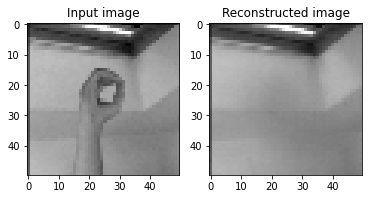

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# vae = torch.load('/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello2/VAE1.pth', map_location=torch.device('cpu'))
vae.eval()
with torch.no_grad():
    for data in random.sample(list(test), 1):
        imgs, _ = data
        imgs = imgs.to(device).float() / 255.0
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.title("Input image")
        plt.imshow(np.squeeze(img), cmap = "gray")
        out, mu, logVAR = vae(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg), cmap = "gray")
        plt.title("Reconstructed image")
        break

Creating an Encoder class with the same structure of the VAE encoder + transfer learning

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        return x

encoder = Encoder()
encoder.encoder.load_state_dict(vae.encoder.state_dict())

<All keys matched successfully>

Defining the convNet that receives as an input the output of the encoder

In [ ]:
class ArtNN(nn.Module):
    def __init__(self):
        super(ArtNN, self).__init__()
        self.encoder = Encoder()
        self.fc1 = nn.Linear(256, 120) 
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 40)
        self.fc4 = nn.Linear(40, 29) 
        self.softmax = nn.LogSoftmax(dim = 1)
    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.softmax(x)
        return x

net = ArtNN().to(device)

In [ ]:
# summary(net, input_size = (1,50,50))

#Training

In [ ]:
learning_rate = 0.001
num_epochs = 100 
loss_train = torch.empty(num_epochs)
loss_val = torch.empty(num_epochs)
acc_train = torch.empty(num_epochs)
acc_val = torch.empty(num_epochs)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, 
                              verbose=True, threshold=0.001) 
early_stopping_rounds = 5  
early_stopping_threshold = 0.0001 

best_loss = float('inf')
num_rounds_no_improve = 0


for epoch in tqdm(range(num_epochs)):
   
    total_acc_train = 0
    total_loss_train = 0
    
    for i, data in enumerate(train, 0):
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_acc_train += (predicted == labels).sum().item()
        
    total_acc_val = 0
    total_loss_val = 0
    
    with torch.no_grad(): 
        for data in validation:
            images, labels = data
            images = images.to(device).float()
            labels = labels.to(device)
            outputs = net(images)
            batch_loss = criterion(outputs, labels)
            total_loss_val += batch_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            acc = (predicted == labels).sum().item()
            total_acc_val += acc
    scheduler.step(total_loss_val/ len(data_valid))    

    if epoch > 0:
        diff_loss = abs(loss_val[epoch-1] - total_loss_val / len(data_valid))
    else:
        diff_loss = float('inf')
        
    if diff_loss < early_stopping_threshold:
        num_rounds_no_improve += 1
    else:
        num_rounds_no_improve = 0
    
    if num_rounds_no_improve == early_stopping_rounds:
        print(f'Early stopping at epoch {epoch}')
        break

    print(
                f'Epoch: {epoch + 1} | Train Loss: {total_loss_train / len(data_train): .3f} \
                | Train Accuracy: {total_acc_train / len(data_train): .3f} \
                | Val Loss: {total_loss_val / len(data_valid): .3f} \
                | Val Accuracy: {total_acc_val / len(data_valid): .3f}')
    loss_train[epoch] = total_loss_train / len(data_train)
    loss_val[epoch] = total_loss_val / len(data_valid)
    acc_train[epoch] = total_acc_train / len(data_train)
    acc_val[epoch] = total_acc_val / len(data_valid)



  1%|          | 1/100 [00:02<03:37,  2.19s/it]

Epoch: 1 | Train Loss:  0.039                 | Train Accuracy:  0.247                 | Val Loss:  0.023                 | Val Accuracy:  0.510


  2%|▏         | 2/100 [00:04<03:34,  2.19s/it]

Epoch: 2 | Train Loss:  0.016                 | Train Accuracy:  0.648                 | Val Loss:  0.010                 | Val Accuracy:  0.772


  3%|▎         | 3/100 [00:06<03:32,  2.19s/it]

Epoch: 3 | Train Loss:  0.008                 | Train Accuracy:  0.825                 | Val Loss:  0.007                 | Val Accuracy:  0.845


  4%|▍         | 4/100 [00:09<03:55,  2.45s/it]

Epoch: 4 | Train Loss:  0.005                 | Train Accuracy:  0.894                 | Val Loss:  0.005                 | Val Accuracy:  0.900


  5%|▌         | 5/100 [00:11<03:48,  2.41s/it]

Epoch: 5 | Train Loss:  0.003                 | Train Accuracy:  0.925                 | Val Loss:  0.005                 | Val Accuracy:  0.906


  6%|▌         | 6/100 [00:14<03:51,  2.46s/it]

Epoch: 6 | Train Loss:  0.003                 | Train Accuracy:  0.944                 | Val Loss:  0.003                 | Val Accuracy:  0.936


  7%|▋         | 7/100 [00:16<03:40,  2.37s/it]

Epoch: 7 | Train Loss:  0.002                 | Train Accuracy:  0.953                 | Val Loss:  0.005                 | Val Accuracy:  0.901


  8%|▊         | 8/100 [00:18<03:33,  2.32s/it]

Epoch: 8 | Train Loss:  0.002                 | Train Accuracy:  0.961                 | Val Loss:  0.002                 | Val Accuracy:  0.955


  9%|▉         | 9/100 [00:20<03:28,  2.29s/it]

Epoch: 9 | Train Loss:  0.002                 | Train Accuracy:  0.968                 | Val Loss:  0.003                 | Val Accuracy:  0.944


 10%|█         | 10/100 [00:23<03:32,  2.36s/it]

Epoch: 10 | Train Loss:  0.001                 | Train Accuracy:  0.976                 | Val Loss:  0.003                 | Val Accuracy:  0.952


 11%|█         | 11/100 [00:25<03:25,  2.31s/it]

Epoch: 11 | Train Loss:  0.002                 | Train Accuracy:  0.961                 | Val Loss:  0.003                 | Val Accuracy:  0.946


 12%|█▏        | 12/100 [00:27<03:20,  2.28s/it]

Epoch: 12 | Train Loss:  0.001                 | Train Accuracy:  0.975                 | Val Loss:  0.003                 | Val Accuracy:  0.943


 13%|█▎        | 13/100 [00:30<03:16,  2.25s/it]

Epoch: 13 | Train Loss:  0.001                 | Train Accuracy:  0.983                 | Val Loss:  0.003                 | Val Accuracy:  0.958


 14%|█▍        | 14/100 [00:32<03:13,  2.24s/it]

Epoch: 14 | Train Loss:  0.001                 | Train Accuracy:  0.978                 | Val Loss:  0.004                 | Val Accuracy:  0.931


 15%|█▌        | 15/100 [00:34<03:12,  2.27s/it]

Epoch: 15 | Train Loss:  0.001                 | Train Accuracy:  0.975                 | Val Loss:  0.002                 | Val Accuracy:  0.960


 16%|█▌        | 16/100 [00:37<03:16,  2.34s/it]

Epoch: 16 | Train Loss:  0.001                 | Train Accuracy:  0.980                 | Val Loss:  0.002                 | Val Accuracy:  0.963


 17%|█▋        | 17/100 [00:39<03:10,  2.30s/it]

Epoch: 17 | Train Loss:  0.001                 | Train Accuracy:  0.981                 | Val Loss:  0.003                 | Val Accuracy:  0.951


 18%|█▊        | 18/100 [00:41<03:05,  2.26s/it]

Epoch: 18 | Train Loss:  0.001                 | Train Accuracy:  0.982                 | Val Loss:  0.003                 | Val Accuracy:  0.953


 19%|█▉        | 19/100 [00:43<03:01,  2.24s/it]

Epoch: 19 | Train Loss:  0.001                 | Train Accuracy:  0.978                 | Val Loss:  0.002                 | Val Accuracy:  0.962


 20%|██        | 20/100 [00:45<02:57,  2.22s/it]

Epoch: 20 | Train Loss:  0.001                 | Train Accuracy:  0.984                 | Val Loss:  0.003                 | Val Accuracy:  0.960


 21%|██        | 21/100 [00:48<02:58,  2.26s/it]

Epoch: 21 | Train Loss:  0.001                 | Train Accuracy:  0.981                 | Val Loss:  0.003                 | Val Accuracy:  0.960


 22%|██▏       | 22/100 [00:51<03:20,  2.57s/it]

Epoch: 22 | Train Loss:  0.001                 | Train Accuracy:  0.987                 | Val Loss:  0.002                 | Val Accuracy:  0.962


 23%|██▎       | 23/100 [00:53<03:08,  2.45s/it]

Epoch: 23 | Train Loss:  0.001                 | Train Accuracy:  0.986                 | Val Loss:  0.002                 | Val Accuracy:  0.965


 24%|██▍       | 24/100 [00:55<03:00,  2.37s/it]

Epoch: 24 | Train Loss:  0.001                 | Train Accuracy:  0.986                 | Val Loss:  0.002                 | Val Accuracy:  0.969


 25%|██▌       | 25/100 [00:58<02:53,  2.31s/it]

Epoch: 25 | Train Loss:  0.001                 | Train Accuracy:  0.982                 | Val Loss:  0.002                 | Val Accuracy:  0.963


 26%|██▌       | 26/100 [01:00<02:47,  2.27s/it]

Epoch: 26 | Train Loss:  0.001                 | Train Accuracy:  0.985                 | Val Loss:  0.004                 | Val Accuracy:  0.940


 27%|██▋       | 27/100 [01:02<02:50,  2.34s/it]

Epoch: 27 | Train Loss:  0.001                 | Train Accuracy:  0.983                 | Val Loss:  0.003                 | Val Accuracy:  0.950


 28%|██▊       | 28/100 [01:05<02:47,  2.33s/it]

Epoch: 28 | Train Loss:  0.000                 | Train Accuracy:  0.995                 | Val Loss:  0.002                 | Val Accuracy:  0.973


 29%|██▉       | 29/100 [01:07<02:42,  2.28s/it]

Epoch: 29 | Train Loss:  0.000                 | Train Accuracy:  0.996                 | Val Loss:  0.003                 | Val Accuracy:  0.959


 30%|███       | 30/100 [01:09<02:37,  2.25s/it]

Epoch: 30 | Train Loss:  0.001                 | Train Accuracy:  0.977                 | Val Loss:  0.002                 | Val Accuracy:  0.961


 31%|███       | 31/100 [01:11<02:33,  2.22s/it]

Epoch: 31 | Train Loss:  0.001                 | Train Accuracy:  0.987                 | Val Loss:  0.003                 | Val Accuracy:  0.960


 32%|███▏      | 32/100 [01:13<02:29,  2.21s/it]

Epoch: 32 | Train Loss:  0.000                 | Train Accuracy:  0.991                 | Val Loss:  0.002                 | Val Accuracy:  0.969


 33%|███▎      | 33/100 [01:17<02:53,  2.59s/it]

Epoch: 33 | Train Loss:  0.000                 | Train Accuracy:  0.994                 | Val Loss:  0.003                 | Val Accuracy:  0.955


 34%|███▍      | 34/100 [01:19<02:42,  2.46s/it]

Epoch: 34 | Train Loss:  0.001                 | Train Accuracy:  0.986                 | Val Loss:  0.003                 | Val Accuracy:  0.951


 35%|███▌      | 35/100 [01:21<02:34,  2.38s/it]

Epoch: 35 | Train Loss:  0.001                 | Train Accuracy:  0.985                 | Val Loss:  0.003                 | Val Accuracy:  0.956


 36%|███▌      | 36/100 [01:23<02:28,  2.31s/it]

Epoch: 36 | Train Loss:  0.001                 | Train Accuracy:  0.987                 | Val Loss:  0.002                 | Val Accuracy:  0.969


 37%|███▋      | 37/100 [01:25<02:22,  2.27s/it]

Epoch: 37 | Train Loss:  0.001                 | Train Accuracy:  0.990                 | Val Loss:  0.002                 | Val Accuracy:  0.966


 38%|███▊      | 38/100 [01:28<02:22,  2.30s/it]

Epoch: 38 | Train Loss:  0.001                 | Train Accuracy:  0.991                 | Val Loss:  0.002                 | Val Accuracy:  0.967


 39%|███▉      | 39/100 [01:30<02:22,  2.33s/it]

Epoch 00039: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 39 | Train Loss:  0.000                 | Train Accuracy:  0.992                 | Val Loss:  0.002                 | Val Accuracy:  0.971


 40%|████      | 40/100 [01:32<02:17,  2.29s/it]

Epoch: 40 | Train Loss:  0.000                 | Train Accuracy:  0.998                 | Val Loss:  0.001                 | Val Accuracy:  0.978


 41%|████      | 41/100 [01:34<02:12,  2.25s/it]

Epoch: 41 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.001                 | Val Accuracy:  0.980


 42%|████▏     | 42/100 [01:37<02:09,  2.23s/it]

Epoch: 42 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.001                 | Val Accuracy:  0.979


 43%|████▎     | 43/100 [01:39<02:06,  2.21s/it]

Epoch: 43 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.001                 | Val Accuracy:  0.979


 44%|████▍     | 44/100 [01:41<02:07,  2.27s/it]

Epoch: 44 | Train Loss:  0.000                 | Train Accuracy:  1.000                 | Val Loss:  0.001                 | Val Accuracy:  0.980


 44%|████▍     | 44/100 [01:44<02:12,  2.37s/it]

Early stopping at epoch 44


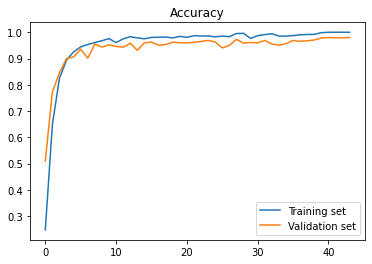

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(acc_train[0:epoch], label='Training set')
ax.plot(acc_val[0:epoch], label='Validation set')
ax.legend()
ax.set_title('Accuracy')
plt.xlabel = 'Epoch'
plt.ylabel = 'Accuracy'
plt.show()

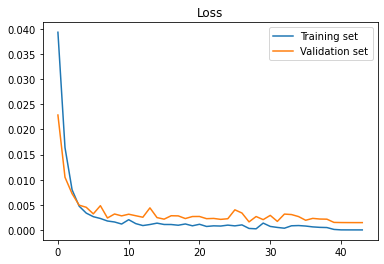

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_train[0:epoch], label = 'Training set')
ax.plot(loss_val[0:epoch], label = 'Validation set')
ax.legend()
ax.set_title('Loss')
plt.xlabel = 'Epoch'
plt.ylabel = 'Loss'
plt.show()

Accuracy on test images: 97 %


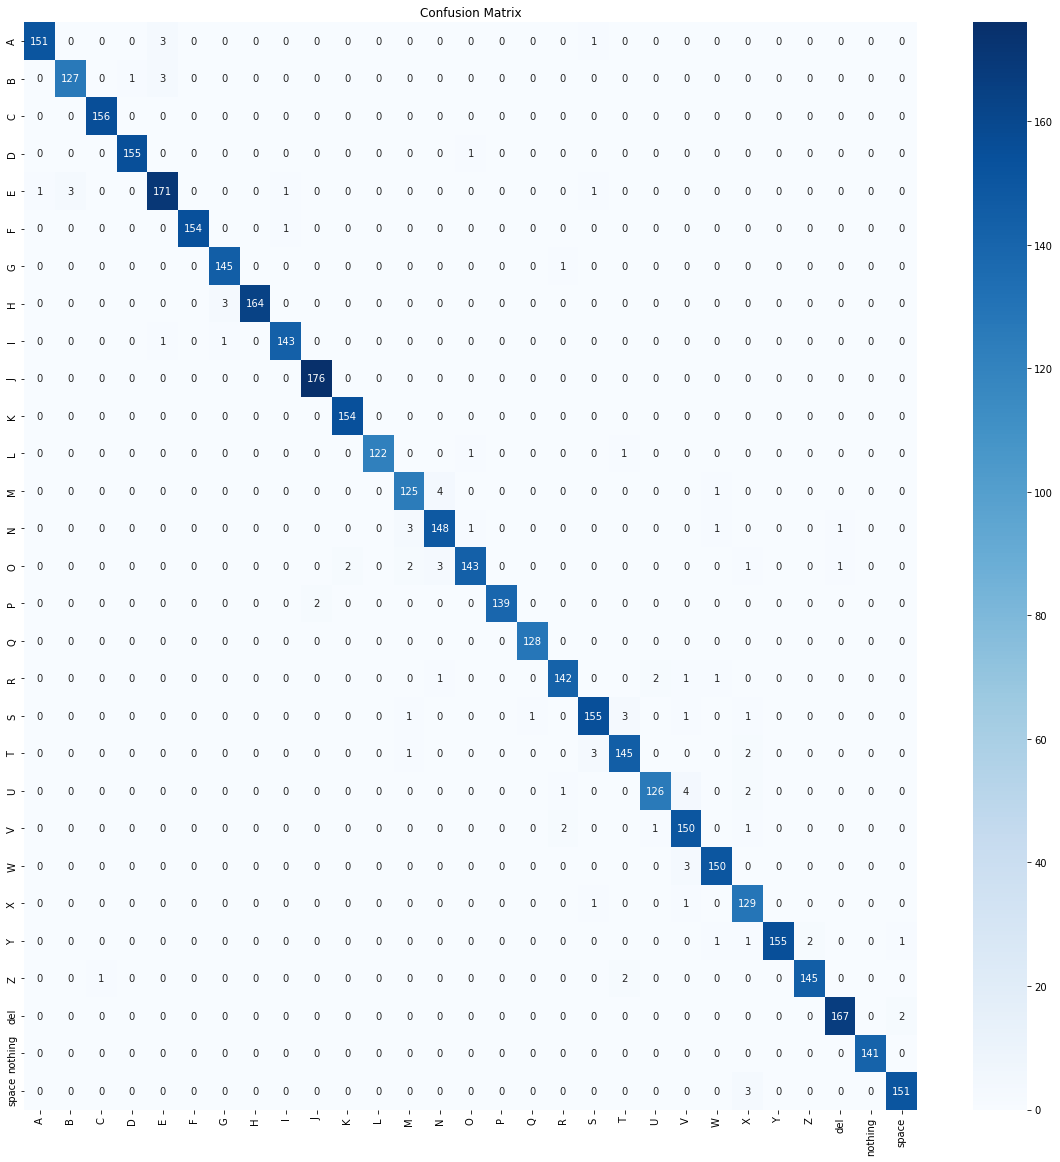

In [ ]:
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in test:
        images, labels = data
        images = images.to(device).float()
        labels = labels.to(device).float()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        correct += (predicted == labels).sum().item()
        
        y_true += labels.cpu().numpy().astype(int).tolist()
        y_pred += predicted.cpu().numpy().tolist()
        
print('Accuracy on test images: %d %%' % (100 * correct / len(ytst)))

# displaying conf matrix
conf_matrix = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_matrix, annot=True, xticklabels = label_dict.keys(), yticklabels = label_dict.keys(), cmap="Blues", fmt="d", ax=ax)

plt.title("Confusion Matrix")
plt.xlabel="Predicted Label"
plt.ylabel="True Label"
plt.show()

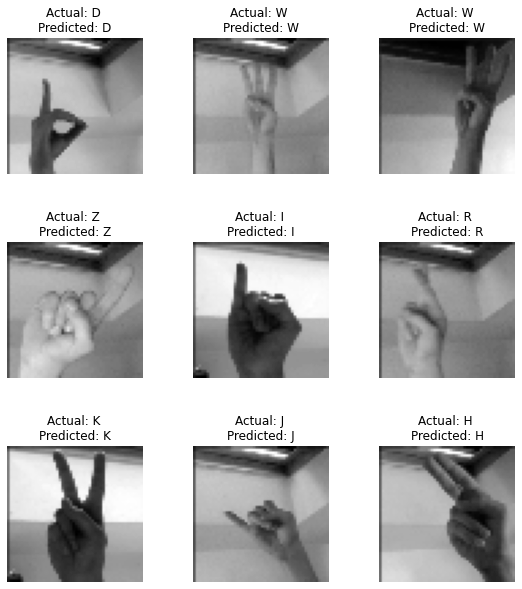

In [ ]:
def get_key_by_value(d, value): 
    for k, v in d.items():
        if v == value:
            return k
    return None

with torch.no_grad():
    for data in test:
        images, labels = data
        images = images.to(device).float()
        labels = labels.to(device).float()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        break 
        
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
plt.subplots_adjust(hspace=0.5, wspace = 0)

k = 0
for i in range(3):
  for j in range(3):
    axs[i,j].imshow(Xtst[k], cmap = "gray")
    axs[i,j].set_title("Actual: "+get_key_by_value(label_dict, ytst[k])+" \nPredicted: "+get_key_by_value(label_dict, predicted[k].tolist()))
    axs[i,j].set_axis_off()
    k += 1

plt.show()

In [ ]:
savePath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello1/VAE1.pth'
torch.save(vae, savePath)

In [ ]:
savePath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello1/VAEandANNnet1.pth'
torch.save(net, savePath)

In [ ]:
saveTensorPath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello2/'+'lossANN1Train.pth'
torch.save(loss_train, saveTensorPath)
saveTensorPath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello2/'+'lossANN1Val.pth'
torch.save(loss_val, saveTensorPath)
saveTensorPath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello2/'+'accANN1Train.pth'
torch.save(acc_train, saveTensorPath)
saveTensorPath = '/content/drive/MyDrive/Secondo Anno Magistrale/Machine Learning/progettoModello2/'+'accANN1Val.pth'
torch.save(acc_val, saveTensorPath)